# Customized Graph Kernel with Fast GRF

This notebook demonstrates the use of a custom GPyTorch kernel based on the Fast Graph Random Features (GRF) approach with sparse implementations optimized for M2 MacBook.

In [29]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import laplacian
import networkx as nx
from sklearn.metrics import mean_squared_error
import sys
import os
import time

# Add paths for importing the custom kernel
sys.path.append('/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs')
sys.path.append('/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs/efficient_graph_gp_sparse')

from efficient_graph_gp_sparse.gptorch_kernels_sparse.general_kernel_fast_grf import GraphGeneralFastGRFKernel

# Check device availability
print(f"PyTorch version: {torch.__version__}")
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"✓ Using MPS device: {device}")
else:
    device = torch.device("cpu")
    print(f"Using CPU device: {device}")

PyTorch version: 2.7.1
✓ Using MPS device: mps


In [30]:
# Generate ring graph dataset
np.random.seed(42)
torch.manual_seed(42)

n_nodes = 50

# Create ring graph (cycle graph)
G = nx.cycle_graph(n_nodes)
A = nx.adjacency_matrix(G).tocsr()

# Generate function that respects ring topology
angles = np.linspace(0, 2*np.pi, n_nodes, endpoint=False)
true_func = lambda theta: 2*np.sin(2*theta) + 0.5*np.cos(4*theta) + 0.3*np.sin(theta)
y_true = true_func(angles)

# Add noise
noise_std = 0.1
y_observed = y_true + np.random.normal(0, noise_std, n_nodes)

# Training/test split
train_idx = np.random.choice(n_nodes, size=int(0.7 * n_nodes), replace=False)
test_idx = np.setdiff1d(np.arange(n_nodes), train_idx)

# Move data to device
X_train = torch.tensor(train_idx, dtype=torch.float32).unsqueeze(1).to(device)
y_train = torch.tensor(y_observed[train_idx], dtype=torch.float32).to(device)
X_test = torch.tensor(test_idx, dtype=torch.float32).unsqueeze(1).to(device)
y_test = torch.tensor(y_observed[test_idx], dtype=torch.float32).to(device)

print(f"Ring graph: {n_nodes} nodes, {G.number_of_edges()} edges")
print(f"Adjacency matrix sparsity: {A.nnz / (n_nodes * n_nodes):.4f}")
print(f"Training set: {len(train_idx)} nodes")
print(f"Test set: {len(test_idx)} nodes")
print(f"Data device: {X_train.device}")

Ring graph: 50 nodes, 50 edges
Adjacency matrix sparsity: 0.0400
Training set: 35 nodes
Test set: 15 nodes
Data device: mps:0


In [31]:
class GraphGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, adjacency_matrix):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        # Use ScaleKernel with our custom graph kernel
        base_kernel = GraphGeneralFastGRFKernel(
            adjacency_matrix=adjacency_matrix,
            walks_per_node=10000,
            p_halt=0.1,
            max_walk_length=3,
            random_walk_seed=42
        )
        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GraphGPModel(X_train, y_train, likelihood, A)

# Move model to device
model = model.to(device)
likelihood = likelihood.to(device)

print("Model initialized successfully!")
print(f"Model device: {next(model.parameters()).device}")

# Check kernel implementation
base_kernel = model.covar_module.base_kernel
if hasattr(base_kernel, 'step_matrices_dense'):
    print(f"✓ Using MPS-optimized dense kernel")
    print(f"Step matrices shape: {base_kernel.step_matrices_dense.shape}")
    print(f"Step matrices device: {base_kernel.step_matrices_dense.device}")
elif hasattr(base_kernel, 'step_matrices'):
    print(f"✓ Using sparse kernel")
    print(f"Number of step matrices: {len(base_kernel.step_matrices)}")

Kernel initialized with 3 step matrices
Using device-aware dense tensors for MPS compatibility
Model initialized successfully!
Model device: mps:0
✓ Using MPS-optimized dense kernel
Step matrices shape: torch.Size([3, 50, 50])
Step matrices device: mps:0


In [32]:
# Training
print("Training model...")
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
start_time = time.time()

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, y_train)
    loss.backward()
    
    if i % 20 == 0:
        print(f'Iter {i+1:3d}/{training_iter} - Loss: {loss.item():.3f} - '
              f'Scale: {model.covar_module.outputscale.item():.3f} - '
              f'Noise: {likelihood.noise.item():.3f}')
    
    optimizer.step()

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f}s")

Training model...
Iter   1/100 - Loss: 2.257 - Scale: 0.693 - Noise: 0.693
Iter  21/100 - Loss: 1.603 - Scale: 1.588 - Noise: 1.078
Iter  41/100 - Loss: 1.329 - Scale: 1.399 - Noise: 0.447
Iter  61/100 - Loss: 0.891 - Scale: 2.425 - Noise: 0.080
Iter  81/100 - Loss: 0.710 - Scale: 1.889 - Noise: 0.017
Iter  41/100 - Loss: 1.329 - Scale: 1.399 - Noise: 0.447
Iter  61/100 - Loss: 0.891 - Scale: 2.425 - Noise: 0.080
Iter  81/100 - Loss: 0.710 - Scale: 1.889 - Noise: 0.017
Training completed in 0.47s
Training completed in 0.47s


In [33]:
# Prediction and evaluation
print("Making predictions...")
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Predict on test nodes
    test_pred = likelihood(model(X_test))
    test_mean = test_pred.mean.cpu()
    test_std = test_pred.stddev.cpu()
    
    # Predict on all nodes for visualization
    X_all = torch.arange(n_nodes, dtype=torch.float32).unsqueeze(1).to(device)
    all_pred = likelihood(model(X_all))
    all_mean = all_pred.mean.cpu()
    all_std = all_pred.stddev.cpu()

# Calculate metrics
test_rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), test_mean.numpy()))
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test noise std: {noise_std:.4f}")
print(f"Final modulator vector: {model.covar_module.base_kernel.modulator_vector.data.cpu().numpy()}")

Making predictions...
Test RMSE: 0.2095
Test noise std: 0.1000
Final modulator vector: [ 1.6394724 -2.4485655  0.8834045]


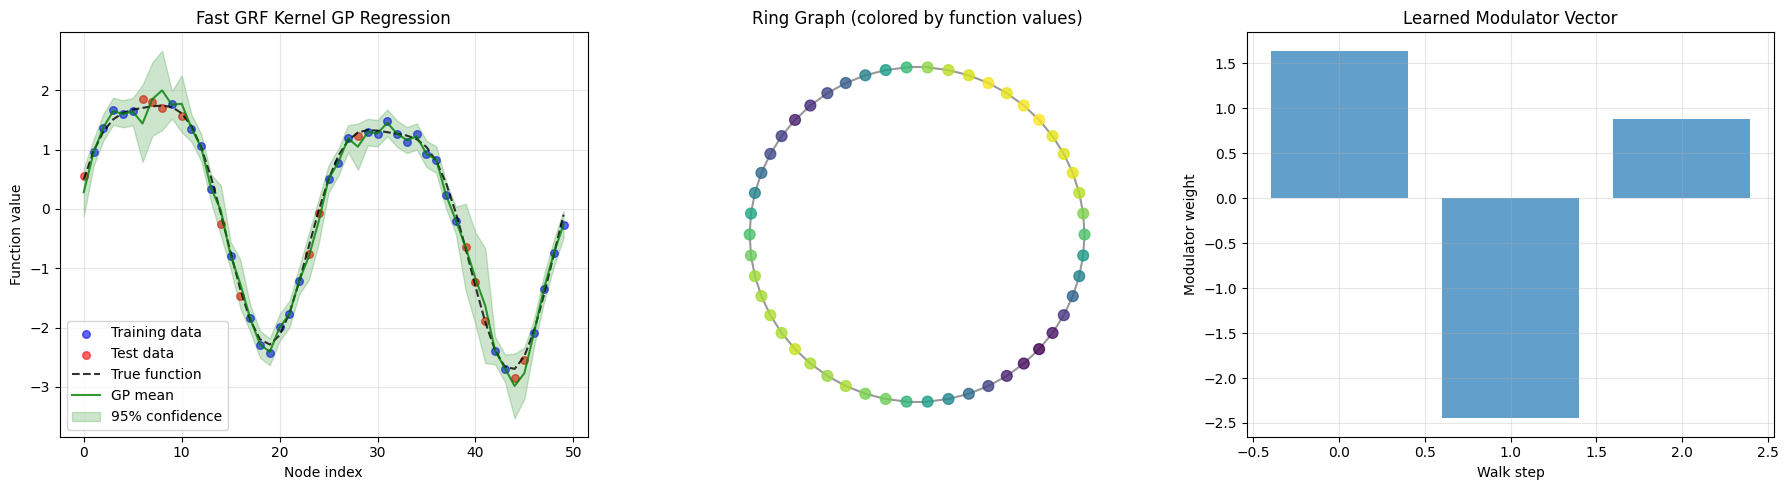


Final results:
Output scale: 1.7611
Noise variance: 0.0068
Modulator vector: [ 1.6394724 -2.4485655  0.8834045]


In [34]:
# Visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: GP predictions vs true function
ax1.scatter(train_idx, y_train.cpu().numpy(), color='blue', alpha=0.6, label='Training data', s=30)
ax1.scatter(test_idx, y_test.cpu().numpy(), color='red', alpha=0.6, label='Test data', s=30)
ax1.plot(range(n_nodes), y_true, 'k--', label='True function', alpha=0.8)
ax1.plot(range(n_nodes), all_mean.numpy(), 'g-', label='GP mean', alpha=0.8)
ax1.fill_between(range(n_nodes), 
                 all_mean.numpy() - 2*all_std.numpy(),
                 all_mean.numpy() + 2*all_std.numpy(),
                 alpha=0.2, color='green', label='95% confidence')
ax1.set_xlabel('Node index')
ax1.set_ylabel('Function value')
ax1.set_title('Fast GRF Kernel GP Regression')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Graph structure (ring layout)
pos = {}
for i in range(n_nodes):
    angle = 2 * np.pi * i / n_nodes
    pos[i] = (np.cos(angle), np.sin(angle))

nx.draw(G, pos, ax=ax2, node_color=y_observed, node_size=60, 
        cmap='viridis', with_labels=False, edge_color='gray', alpha=0.8, width=1.5)
ax2.set_title('Ring Graph (colored by function values)')
ax2.set_aspect('equal')

# Plot 3: Learned modulator vector
modulator = model.covar_module.base_kernel.modulator_vector.data.cpu().numpy()
ax3.bar(range(len(modulator)), modulator, alpha=0.7)
ax3.set_xlabel('Walk step')
ax3.set_ylabel('Modulator weight')
ax3.set_title('Learned Modulator Vector')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal results:")
print(f"Output scale: {model.covar_module.outputscale.item():.4f}")
print(f"Noise variance: {likelihood.noise.item():.4f}")
print(f"Modulator vector: {model.covar_module.base_kernel.modulator_vector.data.cpu().numpy()}")